In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import PIL
import IPython.display as ipd
import librosa
import librosa.display
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_classif

plt.style.use("ggplot")
np.random.seed(42)

# Постановка задачи

Для каждой арабской цифры имеется скан записи на бумаге (`./data/train/image`) и запись произношения на английском языке разными дикторами (`./data/train/voice`)

Требуется построить модель для классификации цифр

In [2]:
IMAGE_TRAIN_PATH = "./data/train/image"
VOICE_TRAIN_PATH = "./data/train/voice"
IMAGE_TEST_PATH = "./data/test/image/"
VOICE_TEST_PATH = "./data/test/voice/"

def read_image(path):
    return PIL.Image.open(path).convert('L')

In [3]:
print(
    os.listdir(IMAGE_TRAIN_PATH)[:10],
    os.listdir(VOICE_TRAIN_PATH)[:10],
    sep='\n\n'
)

['0_0.png', '0_1.png', '0_10.png', '0_100.png', '0_101.png', '0_102.png', '0_103.png', '0_104.png', '0_105.png', '0_106.png']

['0_0.wav', '0_1.wav', '0_10.wav', '0_100.wav', '0_101.wav', '0_102.wav', '0_103.wav', '0_104.wav', '0_105.wav', '0_106.wav']


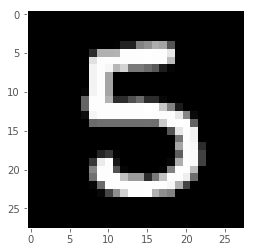

In [4]:
img = read_image(os.path.join(IMAGE_TRAIN_PATH, "5_3.png"))
plt.imshow(img, cmap='gray')
plt.grid(False);

In [5]:
ipd.Audio(os.path.join(VOICE_TRAIN_PATH, "9_100.wav"))

# Обработка только изображений (accuracy до 88)

In [6]:
def extract_image_features(image_folder):
    image_vectors = []
    image_sums = []
    image_vectors0 = []
    image_vectors1 = []
    
    indices = []
    for image_name in os.listdir(image_folder):
        index = os.path.splitext(image_name)[0]
        indices.append(index)
        image = read_image(os.path.join(image_folder, image_name))
        image_vector = np.array(image).reshape(-1)
        image_sum = sum(sum(np.array(image)>50))
        image_vector0 = np.sum(np.array(img)>50, axis = 0)
        image_vector1 = np.sum(np.array(img)>50, axis = 1)
        
        image_vectors.append(image_vector)
        image_sums.append(image_sum)
        image_vectors0.append(image_vector0)
        image_vectors1.append(image_vector1)
    return pd.DataFrame({
        'index': indices,
        'image_vector': image_vectors,
        'image_sum': image_sums,
        'image_vector0': image_vectors0,
        'image_vector1': image_vectors1,
    })

image_features = extract_image_features(IMAGE_TRAIN_PATH)

In [7]:
dataset = image_features
dataset["target"] = dataset["index"].apply(lambda x: int(x[0]))

In [8]:
dataset.head()

,index,image_vector,image_sum,image_vector0,image_vector1,target
0,0_0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",164,"[0, 0, 0, 0, 0, 0, 0, 2, 12, 14, 16, 10, 9, 10...","[0, 0, 0, 0, 5, 10, 11, 9, 3, 3, 3, 6, 12, 13,...",0
1,0_1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",212,"[0, 0, 0, 0, 0, 0, 0, 2, 12, 14, 16, 10, 9, 10...","[0, 0, 0, 0, 5, 10, 11, 9, 3, 3, 3, 6, 12, 13,...",0
2,0_10,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",181,"[0, 0, 0, 0, 0, 0, 0, 2, 12, 14, 16, 10, 9, 10...","[0, 0, 0, 0, 5, 10, 11, 9, 3, 3, 3, 6, 12, 13,...",0
3,0_100,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",159,"[0, 0, 0, 0, 0, 0, 0, 2, 12, 14, 16, 10, 9, 10...","[0, 0, 0, 0, 5, 10, 11, 9, 3, 3, 3, 6, 12, 13,...",0
4,0_101,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",113,"[0, 0, 0, 0, 0, 0, 0, 2, 12, 14, 16, 10, 9, 10...","[0, 0, 0, 0, 5, 10, 11, 9, 3, 3, 3, 6, 12, 13,...",0


In [9]:
train_data, test_data = train_test_split(dataset, test_size = 0.2, random_state =42)

In [10]:
im_vec_full = np.vstack(dataset['image_vector'])
im_vec0_full = np.vstack(dataset['image_vector0'])
im_vec1_full = np.vstack(dataset['image_vector1'])
im_sum_full = np.vstack(dataset['image_sum'])
y_full = np.vstack(dataset['target'])

#im_full = np.concatenate((im_vec_full, im_vec0_full, im_vec1_full, im_sum_full), axis=1)
#im_full = np.concatenate((im_vec_full, im_sum_full), axis=1)
im_full = im_vec_full

Часть пикселей являются шумовыми, их можно убрать с помощью отбора признаков:

In [11]:
skb = SelectKBest(chi2, k=700)
im_full_best = skb.fit_transform(im_full, y_full) # отбираем на всей выборке
im_full_y = np.concatenate((im_full_best, y_full), axis=1)

In [12]:
train_data_im, test_data_im = train_test_split(im_full_y, test_size = 0.2, random_state =42)

In [13]:
X_train_im = train_data_im[:,:-1]
X_test_im = test_data_im[:,:-1]
y_train_im = train_data_im[:,-1]
y_test_im = test_data_im[:,-1]

In [14]:
clf_im = RandomForestClassifier(n_estimators=100, random_state =42).fit(X_train_im, y_train_im)

clf_im.score(X_test_im, y_test_im)

0.8766666666666667

# Обработка звука и построение модели только на нем (Accuracy до 98)

In [15]:
def load_wav(path):
    return librosa.load(path, sr=8000)

Поварьируем параметры mfcc (найдем оптимальную дискретизацию по частоте и по времени)

In [53]:
def extract_voice_features(voice_folder, numcep=30, hop_length=128):
    voice_vectors = []
    #voice_lens = []
    #voice_vectors_1 = []
    #voice_vectors_2 = []
    
    indices = []
    for record_name in os.listdir(voice_folder):
        index = os.path.splitext(record_name)[0]
        indices.append(index)
        signal, sr = load_wav(
            os.path.join(voice_folder, record_name)
        )
        mfcc_features = librosa.feature.mfcc(
            signal, sr=sr, n_mfcc=numcep, hop_length=hop_length
        )
        
        voice_vector = mfcc_features.mean(axis=1)
        #voice_len = len(signal)
        #voice_vector_1 = mfcc_features.mean(axis=0)
        #voice_vector_2 = mfcc_features[:5].reshape(-1)
        
        voice_vectors.append(voice_vector)
        #voice_lens.append(voice_len)
        #voice_vectors_1.append(voice_vector_1)
        #voice_vectors_2.append(voice_vector_2)
        
    return pd.DataFrame({
        'index': indices,
        'voice_vector': voice_vectors,
        #'voice_len': voice_lens,
        #'voice_vector_1': voice_vectors_1,
        #'voice_vector_2': voice_vectors_2,
    })

voice_features = extract_voice_features(VOICE_TRAIN_PATH)

Такие признаки, как длина звуковой записи и усреднения mfcc по другим осям оказались незначимыми и шумовыми, а потому далее не использовались.

In [54]:
dataset = image_features.merge(voice_features, on='index')
dataset["target"] = dataset["index"].apply(lambda x: int(x[0]))

In [55]:
dataset.head()

,index,image_vector,image_sum,image_vector0,image_vector1,target,voice_vector
0,0_0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",164,"[0, 0, 0, 0, 0, 0, 0, 2, 12, 14, 16, 10, 9, 10...","[0, 0, 0, 0, 5, 10, 11, 9, 3, 3, 3, 6, 12, 13,...",0,"[-205.1602006536334, 57.91946870245389, 17.032..."
1,0_1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",212,"[0, 0, 0, 0, 0, 0, 0, 2, 12, 14, 16, 10, 9, 10...","[0, 0, 0, 0, 5, 10, 11, 9, 3, 3, 3, 6, 12, 13,...",0,"[-219.5731069472757, 57.14378737901534, 35.514..."
2,0_10,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",181,"[0, 0, 0, 0, 0, 0, 0, 2, 12, 14, 16, 10, 9, 10...","[0, 0, 0, 0, 5, 10, 11, 9, 3, 3, 3, 6, 12, 13,...",0,"[-400.2382889517981, 54.75083542180288, 0.2431..."
3,0_100,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",159,"[0, 0, 0, 0, 0, 0, 0, 2, 12, 14, 16, 10, 9, 10...","[0, 0, 0, 0, 5, 10, 11, 9, 3, 3, 3, 6, 12, 13,...",0,"[-155.38641365827087, 96.3085790544437, -27.68..."
4,0_101,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",113,"[0, 0, 0, 0, 0, 0, 0, 2, 12, 14, 16, 10, 9, 10...","[0, 0, 0, 0, 5, 10, 11, 9, 3, 3, 3, 6, 12, 13,...",0,"[-329.39376759768044, 52.10905549293906, -14.5..."


In [56]:
train_data, test_data = train_test_split(dataset, test_size = 0.2, random_state =42)

In [57]:
X_train = np.vstack(train_data['voice_vector'])
X_test = np.vstack(test_data['voice_vector'])
y_train = train_data['target']
y_test = test_data['target']

In [58]:
clf_aud = RandomForestClassifier(n_estimators=500, random_state =42).fit(X_train, y_train)

clf_aud.score(X_test, y_test)

0.97

# Соединение признаков по звуку и по изображениям (Accuracy до 93)

In [22]:
X_train_all = np.concatenate((X_train_im, X_train), axis=1)
X_test_all = np.concatenate((X_test_im, X_test), axis=1)

In [23]:
clf_all = RandomForestClassifier(n_estimators=100, random_state =42).fit(X_train_all, y_train)

clf_all.score(X_test_all, y_test)

0.9233333333333333

### Отберем признаки

In [24]:
y_train.shape

(1200,)

In [25]:
skb2 = SelectKBest(f_classif, k=100)
X_train_all_sel = skb2.fit_transform(X_train_all, y_train)
X_test_all_sel = skb2.transform(X_test_all)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: UserWarning: Features [  0  33 363 364 365 391 392 393 419 420 421 447 448 449 475 476 477 503
 504 505 531 532 533 559 560 561 562 586 587 588 589 590 613 614 615 616
 617 618 619 620 640 641 642 643 644 645 646 647 648 665 666 667 668 669
 670 671 672 673 674 675 676 677 678 679 692 693 694 695 696 697 698 699] are constant.
  UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


In [52]:
clf_all = RandomForestClassifier(n_estimators=500, random_state =42).fit(X_train_all_sel, y_train)

clf_all.score(X_test_all_sel, y_test)

0.9366666666666666

In [27]:
y = clf_all.predict(X_test_all_sel)

In [28]:
accuracy_score(y, y_test)

0.9333333333333333

# Сабмитим лучшее

In [59]:
submit_image_features = extract_image_features(IMAGE_TEST_PATH)
submit_voice_features = extract_voice_features(VOICE_TEST_PATH)
submit_dataset = submit_image_features.merge(
    submit_voice_features, 
    on="index"
)
submit_dataset["index"] = submit_dataset["index"].apply(int)

In [60]:
submit_dataset.head()

,index,image_vector,image_sum,image_vector0,image_vector1,voice_vector
0,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",129,"[0, 0, 0, 0, 0, 0, 0, 2, 12, 14, 16, 10, 9, 10...","[0, 0, 0, 0, 5, 10, 11, 9, 3, 3, 3, 6, 12, 13,...","[-320.1903508546853, 94.24897891860319, -19.91..."
1,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",93,"[0, 0, 0, 0, 0, 0, 0, 2, 12, 14, 16, 10, 9, 10...","[0, 0, 0, 0, 5, 10, 11, 9, 3, 3, 3, 6, 12, 13,...","[-376.668805567462, 21.5996558648449, 27.44155..."
2,10,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",91,"[0, 0, 0, 0, 0, 0, 0, 2, 12, 14, 16, 10, 9, 10...","[0, 0, 0, 0, 5, 10, 11, 9, 3, 3, 3, 6, 12, 13,...","[-172.64210373703355, 101.42178038958502, -19...."
3,100,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",64,"[0, 0, 0, 0, 0, 0, 0, 2, 12, 14, 16, 10, 9, 10...","[0, 0, 0, 0, 5, 10, 11, 9, 3, 3, 3, 6, 12, 13,...","[-201.2217792904793, 83.40920742533592, 9.9861..."
4,101,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",144,"[0, 0, 0, 0, 0, 0, 0, 2, 12, 14, 16, 10, 9, 10...","[0, 0, 0, 0, 5, 10, 11, 9, 3, 3, 3, 6, 12, 13,...","[-211.92151790556366, 53.82608395397458, 43.29..."


In [61]:
submit_dataset["target"] = clf_aud.predict(np.vstack(submit_dataset['voice_vector']))

In [62]:
submit_dataset[["index", "target"]] \
    .sort_values("index") \
    .to_csv("4th_submission.csv", index=False)